## Importing the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('max_colwidth', 20000000)
from sklearn import metrics
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import math

### Importing the Raw Dataset from Elasticsearch

In [2]:
df=pd.read_excel(r'G:\Localization\210418\210418.xlsx')
df=df.sort_values(by=['timestamp'])
df.head()

,_id,_index,_score,_type,acceleration,batteryPercentage,cyclicCount,instanceId,nearest,timestamp
8206,1618760836758-0000a7c0,diract-proximity,NaN,_doc,"['-0.125','-0.062','1']",57,0,0000a7c0,"[{'instanceId':'00000058','rssi':-68},{'instanceId':'00000060','rssi':-73}]","Apr 18, 2021 @ 11:47:16"
8205,1618760838159-0000a7c0,diract-proximity,NaN,_doc,"['-0.125','-0.062','1']",57,1,0000a7c0,"[{'instanceId':'00000060','rssi':-73},{'instanceId':'0000004e','rssi':-75}]","Apr 18, 2021 @ 11:47:18"
8204,1618760839729-0000a7c0,diract-proximity,NaN,_doc,"['-0.125','-0.062','1']",57,2,0000a7c0,"[{'instanceId':'00000058','rssi':-68},{'instanceId':'00000060','rssi':-73}]","Apr 18, 2021 @ 11:47:19"
8203,1618760840946-0000a7c0,diract-proximity,NaN,_doc,"['-0.125','-0.062','1']",57,3,0000a7c0,"[{'instanceId':'00000061','rssi':-69},{'instanceId':'00000060','rssi':-73}]","Apr 18, 2021 @ 11:47:20"
8202,1618760842341-0000a7c0,diract-proximity,NaN,_doc,"['-0.125','-0.062','1']",57,5,0000a7c0,"[{'instanceId':'00000061','rssi':-71},{'instanceId':'0000004e','rssi':-75},{'instanceId':'00000060','rssi':-75}]","Apr 18, 2021 @ 11:47:22"


### Pre-Processing the Elasticsearch Raw Dataset 

#### The three instances (detected transmitters) and their corresponding RSSI values are defined. Also,  a column for the Puck is added.

In [3]:
instance_1=df['nearest'].str.slice(16,24,1)
instance_2=df['nearest'].str.slice(53,61,1)
instance_3=df['nearest'].str.slice(90,98,1)

rssi_1=df['nearest'].str.slice(33,36,1)
rssi_2=df['nearest'].str.slice(70,73,1)
rssi_3=df['nearest'].str.slice(107,110,1)
Puck=df['instanceId']

Processed_dataset=pd.DataFrame(df['timestamp'])
Processed_dataset['instance_1']=instance_1
Processed_dataset['instance_2']=instance_2
Processed_dataset['instance_3']=instance_3
Processed_dataset['rssi_1']=rssi_1
Processed_dataset['rssi_2']=rssi_2
Processed_dataset['rssi_3']=rssi_3
Processed_dataset['rssi_3']=rssi_3
Processed_dataset['Puck']=Puck

Processed_dataset=Processed_dataset.reset_index(drop=True)
Processed_dataset=Processed_dataset[Processed_dataset!='']
Processed_dataset.dropna(inplace=True)
Processed_dataset=Processed_dataset.reset_index(drop=True)

# Rarely, the dataset coming from the Kibana has a couple of string values in the RSSI numeric columns.
# Thus, in order for the RSSI columns to be readable for the ML models, we need to remove string characters from them and convert them to integers.
# Since by applying str.extract function the negative sign of RSSI were removed, we need to multiply them by (-1).

Processed_dataset['rssi_1']=pd.DataFrame(Processed_dataset['rssi_1'])['rssi_1'].str.extract(r'(\d+)', expand=False)
Processed_dataset['rssi_2']=pd.DataFrame(Processed_dataset['rssi_2'])['rssi_2'].str.extract(r'(\d+)', expand=False)
Processed_dataset['rssi_3']=pd.DataFrame(Processed_dataset['rssi_3'])['rssi_3'].str.extract(r'(\d+)', expand=False)

Processed_dataset.dropna(inplace=True)

Processed_dataset['rssi_1']=Processed_dataset['rssi_1'].astype(int)
Processed_dataset['rssi_2']=Processed_dataset['rssi_2'].astype(int)
Processed_dataset['rssi_3']=Processed_dataset['rssi_3'].astype(int)

Processed_dataset['rssi_1']=Processed_dataset['rssi_1']*-1
Processed_dataset['rssi_2']=Processed_dataset['rssi_2']*-1
Processed_dataset['rssi_3']=Processed_dataset['rssi_3']*-1

Processed_dataset.head()

,timestamp,instance_1,instance_2,instance_3,rssi_1,rssi_2,rssi_3,Puck
0,"Apr 18, 2021 @ 11:47:22",00000061,0000004e,00000060,-71,-75,-75,0000a7c0
1,"Apr 18, 2021 @ 11:47:23",00000061,0000004e,00000060,-71,-75,-75,0000a7c0
2,"Apr 18, 2021 @ 11:47:25",00000058,00000061,00000060,-68,-74,-75,0000a7c0
3,"Apr 18, 2021 @ 11:47:45",00000058,00000061,00000060,-68,-70,-74,0000a7c0
4,"Apr 18, 2021 @ 11:47:48",00000058,00000061,00000060,-67,-71,-73,0000a7c0


### Converting the Reference Transmitters ID's to (x,y) Coordinates.

In [4]:
Processed_dataset["X1"]=Processed_dataset["instance_1"]
Processed_dataset["X2"]=Processed_dataset["instance_2"]
Processed_dataset["X3"]=Processed_dataset["instance_3"]

Processed_dataset.rename(columns={"instance_1":"Y1"},inplace=True)
Processed_dataset.rename(columns={"instance_2":"Y2"},inplace=True)
Processed_dataset.rename(columns={"instance_3":"Y3"},inplace=True)

# This requires the user to input the (x,y) coordinates for the fixed transmitters on-site.

x_axis={'00000058':3,'00000059':0,'00000060':6,'00000061':3,'0000004d':0,'0000004e':6}
y_axis={'00000058':0,'00000059':3,'00000060':0,'00000061':3,'0000004d':0,'0000004e':3}

Processed_dataset["X1"]=pd.DataFrame(Processed_dataset["Y1"].replace(x_axis))
Processed_dataset["X2"]=pd.DataFrame(Processed_dataset["Y2"].replace(x_axis))
Processed_dataset["X3"]=pd.DataFrame(Processed_dataset["Y3"].replace(x_axis))

Processed_dataset["Y1"]=pd.DataFrame(Processed_dataset["Y1"].replace(y_axis))
Processed_dataset["Y2"]=pd.DataFrame(Processed_dataset["Y2"].replace(y_axis))
Processed_dataset["Y3"]=pd.DataFrame(Processed_dataset["Y3"].replace(y_axis))

# Converting string values of coordiantes to float
df=Processed_dataset
df[['Y1', 'Y2', 'Y3','X1', 'X2', 'X3']]=df[['Y1', 'Y2', 'Y3','X1', 'X2', 'X3']].apply(lambda x: pd.to_numeric(x, errors = 'coerce')).dropna()

df.head()

,timestamp,Y1,Y2,Y3,rssi_1,rssi_2,rssi_3,Puck,X1,X2,X3
0,"Apr 18, 2021 @ 11:47:22",3.0,3.0,0.0,-71,-75,-75,0000a7c0,3.0,6.0,6.0
1,"Apr 18, 2021 @ 11:47:23",3.0,3.0,0.0,-71,-75,-75,0000a7c0,3.0,6.0,6.0
2,"Apr 18, 2021 @ 11:47:25",0.0,3.0,0.0,-68,-74,-75,0000a7c0,3.0,3.0,6.0
3,"Apr 18, 2021 @ 11:47:45",0.0,3.0,0.0,-68,-70,-74,0000a7c0,3.0,3.0,6.0
4,"Apr 18, 2021 @ 11:47:48",0.0,3.0,0.0,-67,-71,-73,0000a7c0,3.0,3.0,6.0


### Determining the Types of the Records

In [5]:
# Calculating the distance between the three detected transmitters
df['dis_12']=np.sqrt(((df['X1']-df['X2'])**2)+((df['Y1']-df['Y2'])**2))
df['dis_13']=np.sqrt(((df['X1']-df['X3'])**2)+((df['Y1']-df['Y3'])**2))
df['dis_23']=np.sqrt(((df['X2']-df['X3'])**2)+((df['Y2']-df['Y3'])**2))

# Type (1) is the Logical recaords

# Condition1
type1=df[(df['dis_12']<4.25)&(df['dis_13']<4.25)&(df['dis_23']<4.25)]
type1=type1.reset_index(drop=True).drop(['dis_12','dis_13','dis_23'],axis=1)

# Type (2) is the Semi-Logical recaords

# Condition1
type2=df[~((df['dis_12']<4.25)&(df['dis_13']<4.25)&(df['dis_23']<4.25))]
# Condition2
type2=type2[type2['dis_12']<4.25]
type2=type2.reset_index(drop=True).drop(['dis_12','dis_13','dis_23'],axis=1)

# Semi-Logical to Logical Converter Model

In [6]:
# Determining the clue point 
type2['Xfin']=((((type2['X1']+type2['X3'])/2)+((type2['X2']+type2['X3'])/2)))/2
type2['yfin']=((((type2['Y1']+type2['Y3'])/2)+((type2['Y2']+type2['Y3'])/2)))/2

# Finding the distance of the clue point from the transmitters
type2['tr_60']=np.sqrt(((type2['Xfin']-6)**2)+((type2['yfin']-0)**2))
type2['tr_4e']=np.sqrt(((type2['Xfin']-6)**2)+((type2['yfin']-3)**2))
type2['tr_61']=np.sqrt(((type2['Xfin']-3)**2)+((type2['yfin']-3)**2))
type2['tr_58']=np.sqrt(((type2['Xfin']-3)**2)+((type2['yfin']-0)**2))
type2['tr_4d']=np.sqrt(((type2['Xfin']-6)**2)+((type2['yfin']-0)**2))
type2['tr_59']=np.sqrt(((type2['Xfin']-6)**2)+((type2['yfin']-3)**2))

#### The already detected transmitters shoud be omitted
def my_fun(x,X1,Y1,X2,Y2,X3,Y3,tr_60,tr_4e,tr_61,tr_58,tr_4d,tr_59):
    
    if ((x[X1]==6)&(x[Y1]==0))|((x[X2]==6)&(x[Y2]==0))|((x[X3]==6)&(x[Y3]==0)):
        x[tr_60]=999999
    else:
        x[tr_60]=x[tr_60]
    return x
type2=type2.apply(lambda x:my_fun(x,'X1','Y1','X2','Y2','X3','Y3','tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59'), axis=1)

def my_fun(x,X1,Y1,X2,Y2,X3,Y3,tr_60,tr_4e,tr_61,tr_58,tr_4d,tr_59):

    if ((x[X1]==6)&(x[Y1]==3))|((x[X2]==6)&(x[Y2]==3))|((x[X3]==6)&(x[Y3]==3)):
        x[tr_4e]=999999
    else:
        x[tr_4e]=x[tr_4e]
    return x 
type2=type2.apply(lambda x:my_fun(x,'X1','Y1','X2','Y2','X3','Y3','tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59'), axis=1)

def my_fun(x,X1,Y1,X2,Y2,X3,Y3,tr_60,tr_4e,tr_61,tr_58,tr_4d,tr_59):

    if ((x[X1]==3)&(x[Y1]==3))|((x[X2]==3)&(x[Y2]==3))|((x[X3]==3)&(x[Y3]==3)):
        x[tr_61]=999999
    else:
        x[tr_61]=x[tr_61]
    return x
type2=type2.apply(lambda x:my_fun(x,'X1','Y1','X2','Y2','X3','Y3','tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59'), axis=1)

def my_fun(x,X1,Y1,X2,Y2,X3,Y3,tr_60,tr_4e,tr_61,tr_58,tr_4d,tr_59):

    if ((x[X1]==3)&(x[Y1]==3))|((x[X2]==3)&(x[Y2]==0))|((x[X3]==3)&(x[Y3]==0)):
        x[tr_58]=999999
    else:
        x[tr_58]=x[tr_58]
    return x 
type2=type2.apply(lambda x:my_fun(x,'X1','Y1','X2','Y2','X3','Y3','tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59'), axis=1)

def my_fun(x,X1,Y1,X2,Y2,X3,Y3,tr_60,tr_4e,tr_61,tr_58,tr_4d,tr_59):

    if ((x[X1]==6)&(x[Y1]==0))|((x[X2]==6)&(x[Y2]==0))|((x[X3]==6)&(x[Y3]==0)):
        x[tr_4d]=999999
    else:
        x[tr_4d]=x[tr_4d]
    return x
type2=type2.apply(lambda x:my_fun(x,'X1','Y1','X2','Y2','X3','Y3','tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59'), axis=1)

def my_fun(x,X1,Y1,X2,Y2,X3,Y3,tr_60,tr_4e,tr_61,tr_58,tr_4d,tr_59):

    if ((x[X1]==6)&(x[Y1]==3))|((x[X2]==6)&(x[Y2]==0))|((x[X3]==6)&(x[Y3]==0)):
        x[tr_59]=999999
    else:
        x[tr_59]=x[tr_59]
    return x 
type2=type2.apply(lambda x:my_fun(x,'X1','Y1','X2','Y2','X3','Y3','tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59'), axis=1)

# The transmitter whose distance from the clue point is the minimum should replace the wrong detected transmitter along with its RSSI value.
type2['corrected_tr_X']=type2[['tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59']].idxmin(axis = 1)
type2['corrected_tr_Y']=type2[['tr_60','tr_4e','tr_61','tr_58','tr_4d','tr_59']].idxmin(axis = 1)

corrected_tr_X={'tr_58':'00000058','tr_59':'00000059','tr_60':'00000060','tr_61':'00000061','tr_4d':'0000004d','tr_4e':'0000004e'}
corrected_tr_Y={'tr_58':'00000058','tr_59':'00000059','tr_60':'00000060','tr_61':'00000061','tr_4d':'0000004d','tr_4e':'0000004e'}

type2['corrected_tr_X']=pd.DataFrame(type2['corrected_tr_X'].replace(corrected_tr_X))
type2['corrected_tr_Y']=pd.DataFrame(type2['corrected_tr_Y'].replace(corrected_tr_Y))

type2['corrected_tr_X']=pd.DataFrame(type2['corrected_tr_X'].replace(x_axis))
type2['corrected_tr_Y']=pd.DataFrame(type2['corrected_tr_Y'].replace(y_axis))

type2[['corrected_tr_X','corrected_tr_Y']]=type2[['corrected_tr_X','corrected_tr_Y']].apply(lambda x: x.astype(float))

type2['X3']=type2['corrected_tr_X']
type2['Y3']=type2['corrected_tr_Y']
type2=type2.drop(['corrected_tr_X','corrected_tr_Y'],axis=1)

type2=type2[['timestamp', 'Y1', 'Y2', 'Y3', 'rssi_1', 'rssi_2', 'rssi_3',
             'Puck','X1', 'X2', 'X3']]

all_data=pd.DataFrame(Processed_dataset['timestamp'])
data=pd.merge(all_data, pd.concat([type1,type2],axis=0), on="timestamp",how='outer').ffill().dropna()
data.head()

,timestamp,Y1,Y2,Y3,rssi_1,rssi_2,rssi_3,Puck,X1,X2,X3
0,"Apr 18, 2021 @ 11:47:22",3.0,3.0,0.0,-71.0,-75.0,-75.0,0000a7c0,3.0,6.0,6.0
1,"Apr 18, 2021 @ 11:47:23",3.0,3.0,0.0,-71.0,-75.0,-75.0,0000a7c0,3.0,6.0,6.0
2,"Apr 18, 2021 @ 11:47:25",0.0,3.0,0.0,-68.0,-74.0,-75.0,0000a7c0,3.0,3.0,6.0
3,"Apr 18, 2021 @ 11:47:45",0.0,3.0,0.0,-68.0,-70.0,-74.0,0000a7c0,3.0,3.0,6.0
4,"Apr 18, 2021 @ 11:47:48",0.0,3.0,0.0,-67.0,-71.0,-73.0,0000a7c0,3.0,3.0,6.0


# RSSI-distance Prediction Model

#### Importing the training dataset to train the RF model to predict the diatance from the RSSI values. The train set consistes four orientation sof the Receiving beacon (Puck) with respect to the transmitter.

In [7]:
Back_dataset=pd.read_csv(r"G:\Final RSSI-distance-1.80 m Height\Back\Back-dataset.csv")
Front_dataset=pd.read_csv(r"G:\Final RSSI-distance-1.80 m Height\Front\Front-dataset.csv")
Right_dataset=pd.read_csv(r"G:\Final RSSI-distance-1.80 m Height\Right\Right-dataset.csv")
Left_dataset=pd.read_csv(r"G:\Final RSSI-distance-1.80 m Height\Left\Lefr-Dataset.csv")

All_dataset=pd.DataFrame()
All_dataset=All_dataset.append([Back_dataset,Front_dataset,Right_dataset,Left_dataset])

"""
We need to filter our desired records based on their distnaces according to the Max diameter of one module.
e.g. here, the records with distnace from 0 to 4.25m are selected. 
"""
Sub_dataset=All_dataset[All_dataset['distance']<=4.25]

"""
As a rule X shoud have a two dimensions (2D) and y should have one dimension (1D). If the taring set has only one attribute,
we should apply .to_numpy().reshape(-1,1) to the X to solve the problem.
"""
X=pd.DataFrame(Sub_dataset['rssi'])
#y=pd.DataFrame(Sub_dataset['distance'])
y=Sub_dataset['distance']

#### Applying the RF model for the RSSI-distance prediction

In [8]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=130,criterion='mse',max_depth=25,min_samples_leaf=8,bootstrap = True,max_features = 'sqrt')
rfc.fit(X,y)

distance_1=rfc.predict(pd.DataFrame(data['rssi_1']))
distance_2=rfc.predict(pd.DataFrame(data['rssi_2']))
distance_3=rfc.predict(pd.DataFrame(data['rssi_3']))

distance_1=pd.DataFrame(distance_1).rename({0:'distance_1',}, axis=1)
distance_2=pd.DataFrame(distance_2).rename({0:'distance_2',}, axis=1)
distance_3=pd.DataFrame(distance_3).rename({0:'distance_3',}, axis=1)

data=pd.concat([data, distance_1.reindex(Processed_dataset.index)], axis=1)
data=pd.concat([data, distance_2.reindex(Processed_dataset.index)], axis=1)
data=pd.concat([data, distance_3.reindex(Processed_dataset.index)], axis=1)

data=data.drop(['rssi_1','rssi_2','rssi_3'], axis=1).dropna()
data=data[['timestamp','Puck','X1','Y1','X2','Y2','X3','Y3','distance_1','distance_2','distance_3']]
df = data

df.head()

,timestamp,Puck,X1,Y1,X2,Y2,X3,Y3,distance_1,distance_2,distance_3
0,"Apr 18, 2021 @ 11:47:22",0000a7c0,3.0,3.0,6.0,3.0,6.0,0.0,3.471563,3.250526,3.250526
1,"Apr 18, 2021 @ 11:47:23",0000a7c0,3.0,3.0,6.0,3.0,6.0,0.0,3.471563,3.250526,3.250526
2,"Apr 18, 2021 @ 11:47:25",0000a7c0,3.0,0.0,3.0,3.0,6.0,0.0,3.361573,3.424589,3.250526
3,"Apr 18, 2021 @ 11:47:45",0000a7c0,3.0,0.0,3.0,3.0,6.0,0.0,3.361573,3.384148,3.424589
4,"Apr 18, 2021 @ 11:47:48",0000a7c0,3.0,0.0,3.0,3.0,6.0,0.0,2.908053,3.471563,3.427018


In [9]:
#data.to_excel(r"C:\Users\ali\Desktop\test_triangulation.xlsx",index=False)

# Estimating the Locations through the Traingualtrion Models

In [10]:
#### Calculating the distance between the three detected transmitters
df['dis_12']=np.sqrt(((df['X1']-df['X2'])**2)+((df['Y1']-df['Y2'])**2))
df['dis_13']=np.sqrt(((df['X1']-df['X3'])**2)+((df['Y1']-df['Y3'])**2))
df['dis_23']=np.sqrt(((df['X2']-df['X3'])**2)+((df['Y2']-df['Y3'])**2))

#### Removing the outliers that a pair of identical transmitters exits in a record
df=df[(df['dis_12']!=0)&(df['dis_13']!=0)&(df['dis_23']!=0)]

#### Defining rules to check if a pair of circles intersect each other or are isolated.

In [11]:
#check1_1,check1_2
def my_fun(x):  
    
    if x['dis_12']>(x['distance_1']+x['distance_2']):
        x['check1_1']=1
    else:
        x['check1_1']=0
    return x
df=df.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if x['dis_12']<abs(x['distance_1']-x['distance_2']):
        x['check1_2']=1
    else:
        x['check1_2']=0
    return x
df=df.apply(lambda x:my_fun(x), axis=1)


#check2_1,check2_2
def my_fun(x):  
    
    if x['dis_23']>(x['distance_2']+x['distance_3']):
        x['check2_1']=1
    else:
        x['check2_1']=0
    return x
df=df.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if x['dis_23']<abs(x['distance_2']-x['distance_3']):
        x['check2_2']=1
    else:
        x['check2_2']=0
    return x
df=df.apply(lambda x:my_fun(x), axis=1)


#check3_1,check3_2
def my_fun(x):  
    
    if x['dis_13']>(x['distance_1']+x['distance_3']):
        x['check3_1']=1
    else:
        x['check3_1']=0
    return x
df=df.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if x['dis_13']<abs(x['distance_1']-x['distance_3']):
        x['check3_2']=1
    else:
        x['check3_2']=0
    return x
df=df.apply(lambda x:my_fun(x), axis=1)

### Categorizing the placements of the circles with respect to each other

### Type1 ( one circle is isolated and the other two intersect each other)

In [12]:
# In type1, we have 3 different sub-types based on which circle is isolated.

type1_1=df[(df['check1_1']==0)&(df['check1_2']==0)&
(df['check2_1']==1)&(df['check2_2']==0)&
(df['check3_1']==1)&(df['check3_2']==0)]

type1_2=df[(df['check1_1']==1)&(df['check1_2']==0)&
(df['check2_1']==0)&(df['check2_2']==0)&
(df['check3_1']==1)&(df['check3_2']==0)]

type1_3=df[(df['check1_1']==1)&(df['check1_2']==0)&
(df['check2_1']==1)&(df['check2_2']==0)&
(df['check3_1']==0)&(df['check3_2']==0)]

### Triangulation Algorithm for Type1

### type1_1

In [13]:
#### Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_2']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    else:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_1']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_12'])*(x['X2']-x['X1'])
    else:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_12'])*(x['X1']-x['X2'])
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X3']-x['X4_1'])**2)+((x['Y3']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X3']-x['X4_2'])**2)+((x['Y3']-x['Y4_2'])**2))    
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type1_1['location_X']=0
type1_1['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_X']=x['X4_2']
    else:
        x['location_X']=x['X4_1']
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_Y']=x['Y4_2']
    else:
        x['location_Y']=x['Y4_1']
    return x
type1_1=type1_1.apply(lambda x:my_fun(x), axis=1)

type1_1=type1_1[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

## type1_2

In [14]:
#### Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_3']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_2']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_23'])*(x['X3']-x['X2'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_23'])*(x['X2']-x['X3'])
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X1']-x['X4_1'])**2)+((x['Y1']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X1']-x['X4_2'])**2)+((x['Y1']-x['Y4_2'])**2))    
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type1_2['location_X']=0
type1_2['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_X']=x['X4_2']
    else:
        x['location_X']=x['X4_1']
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_Y']=x['Y4_2']
    else:
        x['location_Y']=x['Y4_1']
    return x
type1_2=type1_2.apply(lambda x:my_fun(x), axis=1)

type1_2=type1_2[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

## type1_3

In [15]:
#### Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_3']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_1']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_13'])*(x['X3']-x['X1'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_13'])*(x['X1']-x['X3'])
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X2']-x['X4_1'])**2)+((x['Y2']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X2']-x['X4_2'])**2)+((x['Y2']-x['Y4_2'])**2))    
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type1_3['location_X']=0
type1_3['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_X']=x['X4_2']
    else:
        x['location_X']=x['X4_1']
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_Y']=x['Y4_2']
    else:
        x['location_Y']=x['Y4_1']
    return x
type1_3=type1_3.apply(lambda x:my_fun(x), axis=1)

type1_3=type1_3[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

### Type2 (all the circles intersect each other)

In [16]:
# In type2, the three circles intersect each other

type2=df[(df['check1_1']==0)&(df['check1_2']==0)&
(df['check2_1']==0)&(df['check2_2']==0)&
(df['check3_1']==0)&(df['check3_2']==0)]

In [17]:
#### Finding intersections of circles of 1 and 2

######## Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_2']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    else:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_1']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_12'])*(x['X2']-x['X1'])
    else:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_12'])*(x['X1']-x['X2'])
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X3']-x['X4_1'])**2)+((x['Y3']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X3']-x['X4_2'])**2)+((x['Y3']-x['Y4_2'])**2))    
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type2['location_X']=0
type2['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_X']=x['X4_2']
    else:
        x['location_P1_X']=x['X4_1']
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_Y']=x['Y4_2']
    else:
        x['location_P1_Y']=x['Y4_1']
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding intersections of circles of 2 and 3

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_3']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_2']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_23'])*(x['X3']-x['X2'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_23'])*(x['X2']-x['X3'])
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X1']-x['X4_1'])**2)+((x['Y1']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X1']-x['X4_2'])**2)+((x['Y1']-x['Y4_2'])**2))    
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type2['location_X']=0
type2['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_X']=x['X4_2']
    else:
        x['location_P2_X']=x['X4_1']
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_Y']=x['Y4_2']
    else:
        x['location_P2_Y']=x['Y4_1']
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding intersections of circles of 1 and 3

#### Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_3']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_1']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_13'])*(x['X3']-x['X1'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_13'])*(x['X1']-x['X3'])
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X2']-x['X4_1'])**2)+((x['Y2']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X2']-x['X4_2'])**2)+((x['Y2']-x['Y4_2'])**2))    
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type2['location_X']=0
type2['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P3_X']=x['X4_2']
    else:
        x['location_P3_X']=x['X4_1']
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P3_Y']=x['Y4_2']
    else:
        x['location_P3_Y']=x['Y4_1']
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

#### Taking an average of the intersection points

def my_fun(x):  
    
    x['location_X']=(x['location_P1_X']+x['location_P2_X']+x['location_P3_X'])/3
    x['location_Y']=(x['location_P1_Y']+x['location_P2_Y']+x['location_P3_Y'])/3  
    return x
type2=type2.apply(lambda x:my_fun(x), axis=1)

type2=type2[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

### Type3 (two pairs of circles inrtersect with each other)

In [18]:
# In type3, we have 3 different sub-type based on which circle intersects with the other circles.

type3_1=df[(df['check1_1']==0)&(df['check1_2']==0)&
(df['check2_1']==1)&(df['check2_2']==0)&
(df['check3_1']==0)&(df['check3_2']==0)]

type3_2=df[(df['check1_1']==0)&(df['check1_2']==0)&
(df['check2_1']==0)&(df['check2_2']==0)&
(df['check3_1']==1)&(df['check3_2']==0)]

type3_3=df[(df['check1_1']==1)&(df['check1_2']==0)&
(df['check2_1']==0)&(df['check2_2']==0)&
(df['check3_1']==0)&(df['check3_2']==0)]

In [19]:
### type3_1

#### Finding intersections of the first pair

######## Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_2']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    else:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_1']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_12'])*(x['X2']-x['X1'])
    else:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_12'])*(x['X1']-x['X2'])
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X3']-x['X4_1'])**2)+((x['Y3']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X3']-x['X4_2'])**2)+((x['Y3']-x['Y4_2'])**2))    
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type3_1['location_X']=0
type3_1['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_X']=x['X4_2']
    else:
        x['location_P1_X']=x['X4_1']
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_Y']=x['Y4_2']
    else:
        x['location_P1_Y']=x['Y4_1']
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding intersections of the second pair

#### Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_3']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_1']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_13'])*(x['X3']-x['X1'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_13'])*(x['X1']-x['X3'])
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X2']-x['X4_1'])**2)+((x['Y2']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X2']-x['X4_2'])**2)+((x['Y2']-x['Y4_2'])**2))    
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type3_1['location_X']=0
type3_1['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_X']=x['X4_2']
    else:
        x['location_P2_X']=x['X4_1']
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_Y']=x['Y4_2']
    else:
        x['location_P2_Y']=x['Y4_1']
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

#### Taking an average of the intersection points

def my_fun(x):  
    
    x['location_X']=(x['location_P1_X']+x['location_P2_X'])/2
    x['location_Y']=(x['location_P1_Y']+x['location_P2_Y'])/2  
    return x
type3_1=type3_1.apply(lambda x:my_fun(x), axis=1)

type3_1=type3_1[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

### type3_2

In [20]:
#### Finding intersections of the first pair

######## Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_2']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    else:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_1']**2)+(x['dis_12']**2))/(2*x['dis_12'])
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_12'])*(x['X2']-x['X1'])
    else:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_12'])*(x['X1']-x['X2'])
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y2']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_12'])*(x['Y1']-x['Y2']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_2']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X2']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_12'])*(x['X1']-x['X2']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X3']-x['X4_1'])**2)+((x['Y3']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X3']-x['X4_2'])**2)+((x['Y3']-x['Y4_2'])**2))    
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type3_2['location_X']=0
type3_2['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_X']=x['X4_2']
    else:
        x['location_P1_X']=x['X4_1']
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_Y']=x['Y4_2']
    else:
        x['location_P1_Y']=x['Y4_1']
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding intersections of the second pair

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_3']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_2']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_23'])*(x['X3']-x['X2'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_23'])*(x['X2']-x['X3'])
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X1']-x['X4_1'])**2)+((x['Y1']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X1']-x['X4_2'])**2)+((x['Y1']-x['Y4_2'])**2))    
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type3_2['location_X']=0
type3_2['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_X']=x['X4_2']
    else:
        x['location_P2_X']=x['X4_1']
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_Y']=x['Y4_2']
    else:
        x['location_P2_Y']=x['Y4_1']
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

#### Taking an average of the intersection points

def my_fun(x):  
    
    x['location_X']=(x['location_P1_X']+x['location_P2_X'])/2
    x['location_Y']=(x['location_P1_Y']+x['location_P2_Y'])/2  
    return x
type3_2=type3_2.apply(lambda x:my_fun(x), axis=1)

type3_2=type3_2[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

### type3_3

In [21]:
#### Finding intersections of the first pair

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_a']=((x['distance_2']**2)-(x['distance_3']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_2']**2)+(x['dis_23']**2))/(2*x['dis_23'])
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_2']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_X']=x['X2']+(x['intersections_a']/x['dis_23'])*(x['X3']-x['X2'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_23'])*(x['X2']-x['X3'])
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['P3_Y']=x['Y2']+((x['intersections_a']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y3']-x['Y2']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_23'])*(x['Y2']-x['Y3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_2']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X3']-x['X2']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_23'])*(x['X2']-x['X3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X1']-x['X4_1'])**2)+((x['Y1']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X1']-x['X4_2'])**2)+((x['Y1']-x['Y4_2'])**2))    
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type3_3['location_X']=0
type3_3['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_X']=x['X4_2']
    else:
        x['location_P1_X']=x['X4_1']
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P1_Y']=x['Y4_2']
    else:
        x['location_P1_Y']=x['Y4_1']
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment a named 'intersections_a'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_a']=((x['distance_1']**2)-(x['distance_3']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    else:
        x['intersections_a']=((x['distance_3']**2)-(x['distance_1']**2)+(x['dis_13']**2))/(2*x['dis_13'])
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the segment h named 'intersections_h'

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['intersections_h']=np.sqrt((x['distance_1']**2)-(x['intersections_a']**2))
    else:
        x['intersections_h']=np.sqrt((x['distance_3']**2)-(x['intersections_a']**2))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the point P3 (in vector form of X and Y)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_X']=x['X1']+(x['intersections_a']/x['dis_13'])*(x['X3']-x['X1'])
    else:
        x['P3_X']=x['X3']+(x['intersections_a']/x['dis_13'])*(x['X1']-x['X3'])
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['P3_Y']=x['Y1']+((x['intersections_a']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['P3_Y']=x['Y3']+((x['intersections_a']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Getting the pair of points

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_1']=x['P3_X']+((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_1']=x['P3_Y']-((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y3']-x['Y1']))
    else:
        x['X4_2']=x['P3_X']-((x['intersections_h']/x['dis_13'])*(x['Y1']-x['Y3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['distance_1']>x['distance_3']:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X3']-x['X1']))
    else:
        x['Y4_2']=x['P3_Y']+((x['intersections_h']/x['dis_13'])*(x['X1']-x['X3']))
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Finding the distance of the intersection points from the center of the isolated circle

def my_fun(x):  
    
    x['intersection1_distance']=np.sqrt(((x['X2']-x['X4_1'])**2)+((x['Y2']-x['Y4_1'])**2))
    x['intersection2_distance']=np.sqrt(((x['X2']-x['X4_2'])**2)+((x['Y2']-x['Y4_2'])**2))    
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Determining the nearest intersection point to the isolated circle

#Just in case, if there is no record in this type, so we need manually create columns of 'location_X'
# and 'location_Y' in order for the model not to break.

type3_3['location_X']=0
type3_3['location_Y']=0

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_X']=x['X4_2']
    else:
        x['location_P2_X']=x['X4_1']
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

def my_fun(x):  
    
    if  x['intersection1_distance']>x['intersection2_distance']:
        x['location_P2_Y']=x['Y4_2']
    else:
        x['location_P2_Y']=x['Y4_1']
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

#### Taking an average of the intersection points

def my_fun(x):  
    
    x['location_X']=(x['location_P1_X']+x['location_P2_X'])/2
    x['location_Y']=(x['location_P1_Y']+x['location_P2_Y'])/2  
    return x
type3_3=type3_3.apply(lambda x:my_fun(x), axis=1)

type3_3=type3_3[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

### Type4 (the circles don't intersect each other)

In [22]:
type4=df[(df['check1_1']==1)&(df['check1_2']==0)&
(df['check2_1']==1)&(df['check2_2']==0)&
(df['check3_1']==1)&(df['check3_2']==0)]

In [23]:
# Min-Max method:
def my_fun(x):  
    
    x['Xmin']=max((x['X1']-x['distance_1']),(x['X2']-x['distance_2']),(x['X3']-x['distance_3']))
    x['Xmax']=min((x['X1']+x['distance_1']),(x['X2']+x['distance_2']),(x['X3']+x['distance_3']))
    x['Ymin']=max((x['Y1']-x['distance_1']),(x['Y2']-x['distance_2']),(x['Y3']-x['distance_3']))
    x['Ymax']=min((x['Y1']+x['distance_1']),(x['Y2']+x['distance_2']),(x['Y3']+x['distance_3']))
    x['location_X']=(x['Xmin']+x['Xmax'])/2
    x['location_Y']=(x['Ymin']+x['Ymax'])/2    
    return x
type4=type4.apply(lambda x:my_fun(x), axis=1)

type4=type4[['timestamp', 'Puck', 'X1', 'Y1', 'distance_1','distance_2', 'distance_3','location_X', 'location_Y']]

### Concat all the estimated locations of the four categories

In [24]:
all_locations=pd.concat([type1_1,type1_2,type1_3,type2,type3_1,type3_2,type3_3,type4],axis=0).sort_values('timestamp').reset_index(drop=True)

## Post-Processing the Estimated Locations

### Shifting the estimated locations toward to the strongest transmitter

In [25]:
# In rare cases, the estimated distance is zero. So, this can affects the divison lines bellow. Hence, we add 0.000001 to the distances. 
def my_fun(x):  
    
    x['distance_1']=x['distance_1']+0.000001
    x['distance_2']=x['distance_2']+0.000001
    x['location_X']=((x['location_X']+x['X1']*(0.2*(x['distance_2'])/x['distance_1']))/(1+(0.2*(x['distance_2'])/x['distance_1'])))
    x['location_Y']=((x['location_Y']+x['Y1']*(0.2*(x['distance_2'])/x['distance_1']))/(1+(0.2*(x['distance_2'])/x['distance_1'])))
    return x

all_locations=all_locations.apply(lambda x:my_fun(x), axis=1)

all_locations=all_locations[['timestamp', 'Puck','location_X', 'location_Y']]

### Applying Kalman Filtering

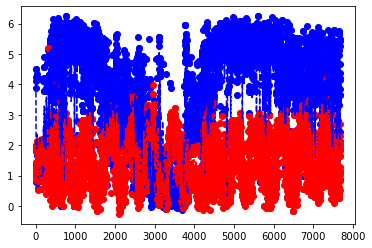

In [26]:
dff=all_locations[['location_X','location_Y']]

measurements =np.asarray(dff)

initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

kf1 = kf1.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)


kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 5 *kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

kf2 = kf2.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)


plt.figure(1)
times = range(measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',         times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()


Smooth=pd.DataFrame(smoothed_state_means[:]).rename(columns={0:'location_X',2:'location_Y'})[['location_X','location_Y']]

## Exporting the Dataset

In [27]:
final=pd.concat([all_locations[['timestamp','Puck']], Smooth], axis=1)
final.to_excel(r"C:\Users\ali\Desktop\test_location.xlsx",index=False)